# اتصال به گوگل درایو


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# نصب و فراخوانی کتابخانه های مورد نیاز

## نصب کتابخانه‌های ناموجود

In [3]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107730 sha256=b46109c0a569fb1e57bc6ae8bc05acec9f446ca3b1758d5f625a0496397b8b93
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [4]:
!pip install imbalanced-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## فراخوانی کتابخانه‌ها

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
#from catboost import CatBoostClassifier
import lightgbm as lgb

# تنظیمات

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
pd.set_option('display.max_columns', None)

# فراخوانی مجموعه داده

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/مواد پایان نامه/مجموعه داده پیش پردازش شده مرحله ۱/iot23-sampled-P1.csv')

In [ ]:
df = df.drop('Unnamed: 0', axis=1)
df

,ts,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,1.540469e+09,192.168.1.132,58687.0,216.239.35.4,123.0,udp,SF,Dd,1.0,76.0,1.0,76.0,Benign
1,1.540469e+09,192.168.1.132,1900.0,239.255.255.250,1900.0,udp,S0,D,24.0,8208.0,0.0,0.0,Benign
2,1.540469e+09,192.168.1.132,32893.0,216.239.35.8,123.0,udp,SF,Dd,1.0,76.0,1.0,76.0,Benign
3,1.540470e+09,192.168.1.132,53395.0,2.16.60.82,443.0,tcp,SF,Other,5.0,212.0,3.0,144.0,Benign
4,1.540470e+09,192.168.1.132,52801.0,192.168.1.1,53.0,udp,SF,Dd,1.0,62.0,1.0,339.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173109,1.569018e+09,192.168.1.195,11801.0,162.248.88.215,62336.0,tcp,OTH,C,0.0,0.0,0.0,0.0,DDoS
173110,1.569018e+09,192.168.1.195,2837.0,162.248.88.215,62336.0,tcp,OTH,C,0.0,0.0,0.0,0.0,DDoS
173111,1.569018e+09,192.168.1.195,1966.0,162.248.88.215,62336.0,tcp,OTH,C,0.0,0.0,0.0,0.0,DDoS
173112,1.569018e+09,192.168.1.195,40430.0,162.248.88.215,62336.0,tcp,OTH,C,0.0,0.0,0.0,0.0,DDoS


# مرتب کردن ستون‌ها بر اساس جنس داده

In [ ]:
# get object type columns except target
obj_cols = [col for col in df.columns if df[col].dtype == 'object' and col != 'label']

# get non-object type columns
non_obj_cols = [col for col in df.columns if col not in obj_cols and col != 'label']

# re-arrange columns in desired order
new_cols = obj_cols + non_obj_cols + ['label']

# create new dataframe with re-arranged columns
df = df[new_cols]


In [ ]:
df

,id.orig_h,id.resp_h,proto,conn_state,history,ts,id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,192.168.1.132,216.239.35.4,udp,SF,Dd,1.540469e+09,58687.0,123.0,1.0,76.0,1.0,76.0,Benign
1,192.168.1.132,239.255.255.250,udp,S0,D,1.540469e+09,1900.0,1900.0,24.0,8208.0,0.0,0.0,Benign
2,192.168.1.132,216.239.35.8,udp,SF,Dd,1.540469e+09,32893.0,123.0,1.0,76.0,1.0,76.0,Benign
3,192.168.1.132,2.16.60.82,tcp,SF,Other,1.540470e+09,53395.0,443.0,5.0,212.0,3.0,144.0,Benign
4,192.168.1.132,192.168.1.1,udp,SF,Dd,1.540470e+09,52801.0,53.0,1.0,62.0,1.0,339.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173109,192.168.1.195,162.248.88.215,tcp,OTH,C,1.569018e+09,11801.0,62336.0,0.0,0.0,0.0,0.0,DDoS
173110,192.168.1.195,162.248.88.215,tcp,OTH,C,1.569018e+09,2837.0,62336.0,0.0,0.0,0.0,0.0,DDoS
173111,192.168.1.195,162.248.88.215,tcp,OTH,C,1.569018e+09,1966.0,62336.0,0.0,0.0,0.0,0.0,DDoS
173112,192.168.1.195,162.248.88.215,tcp,OTH,C,1.569018e+09,40430.0,62336.0,0.0,0.0,0.0,0.0,DDoS


# کد گزاری داده‌های اسمی

## کد گذاری ستون های ای دی

In [ ]:
# Create a dictionary with the frequency count of each unique value in the id.orig_h column
id_orig_h_freq = df['id.orig_h'].value_counts().to_dict()

# Create a dictionary with the frequency count of each unique value in the id.resp_h column
id_resp_h_freq = df['id.resp_h'].value_counts().to_dict()

# Map the frequency counts to the respective columns in the dataframe
df['id.orig_h_freq'] = df['id.orig_h'].map(id_orig_h_freq)
df['id.resp_h_freq'] = df['id.resp_h'].map(id_resp_h_freq)


In [ ]:
df

,id.orig_h,id.resp_h,proto,conn_state,history,ts,id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,id.orig_h_freq,id.resp_h_freq
0,192.168.1.132,216.239.35.4,udp,SF,Dd,1.540469e+09,58687.0,123.0,1.0,76.0,1.0,76.0,Benign,452,26
1,192.168.1.132,239.255.255.250,udp,S0,D,1.540469e+09,1900.0,1900.0,24.0,8208.0,0.0,0.0,Benign,452,15
2,192.168.1.132,216.239.35.8,udp,SF,Dd,1.540469e+09,32893.0,123.0,1.0,76.0,1.0,76.0,Benign,452,26
3,192.168.1.132,2.16.60.82,tcp,SF,Other,1.540470e+09,53395.0,443.0,5.0,212.0,3.0,144.0,Benign,452,47
4,192.168.1.132,192.168.1.1,udp,SF,Dd,1.540470e+09,52801.0,53.0,1.0,62.0,1.0,339.0,Benign,452,1962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173109,192.168.1.195,162.248.88.215,tcp,OTH,C,1.569018e+09,11801.0,62336.0,0.0,0.0,0.0,0.0,DDoS,19991,9988
173110,192.168.1.195,162.248.88.215,tcp,OTH,C,1.569018e+09,2837.0,62336.0,0.0,0.0,0.0,0.0,DDoS,19991,9988
173111,192.168.1.195,162.248.88.215,tcp,OTH,C,1.569018e+09,1966.0,62336.0,0.0,0.0,0.0,0.0,DDoS,19991,9988
173112,192.168.1.195,162.248.88.215,tcp,OTH,C,1.569018e+09,40430.0,62336.0,0.0,0.0,0.0,0.0,DDoS,19991,9988


## کدگذاری بقیه ستون‌های‌ اسمی

In [ ]:
proto_dummies = pd.get_dummies(df["proto"], prefix="proto")

# create dummy variables for "conn_state" column
conn_state_dummies = pd.get_dummies(df["conn_state"], prefix="conn_state")

# create dummy variables for "history" column
history_dummies = pd.get_dummies(df["history"], prefix="history")

# concatenate the original dataframe with the new dummy variable dataframes
df = pd.concat([df, proto_dummies, conn_state_dummies, history_dummies], axis=1)



In [ ]:
df

,id.orig_h,id.resp_h,proto,conn_state,history,ts,id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,id.orig_h_freq,id.resp_h_freq,proto_icmp,proto_tcp,proto_udp,conn_state_OTH,conn_state_Other,conn_state_REJ,conn_state_RSTOS0,conn_state_RSTR,conn_state_S0,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_I,history_Other,history_S,history_ShAdDaf
0,192.168.1.132,216.239.35.4,udp,SF,Dd,1.540469e+09,58687.0,123.0,1.0,76.0,1.0,76.0,Benign,452,26,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,192.168.1.132,239.255.255.250,udp,S0,D,1.540469e+09,1900.0,1900.0,24.0,8208.0,0.0,0.0,Benign,452,15,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,192.168.1.132,216.239.35.8,udp,SF,Dd,1.540469e+09,32893.0,123.0,1.0,76.0,1.0,76.0,Benign,452,26,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,192.168.1.132,2.16.60.82,tcp,SF,Other,1.540470e+09,53395.0,443.0,5.0,212.0,3.0,144.0,Benign,452,47,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,192.168.1.132,192.168.1.1,udp,SF,Dd,1.540470e+09,52801.0,53.0,1.0,62.0,1.0,339.0,Benign,452,1962,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173109,192.168.1.195,162.248.88.215,tcp,OTH,C,1.569018e+09,11801.0,62336.0,0.0,0.0,0.0,0.0,DDoS,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
173110,192.168.1.195,162.248.88.215,tcp,OTH,C,1.569018e+09,2837.0,62336.0,0.0,0.0,0.0,0.0,DDoS,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
173111,192.168.1.195,162.248.88.215,tcp,OTH,C,1.569018e+09,1966.0,62336.0,0.0,0.0,0.0,0.0,DDoS,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
173112,192.168.1.195,162.248.88.215,tcp,OTH,C,1.569018e+09,40430.0,62336.0,0.0,0.0,0.0,0.0,DDoS,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
df_encoded = df
# drop the original "proto", "conn_state", and "history" columns
df_encoded = df_encoded.drop(["proto", "conn_state", "history", "id.orig_h", "id.resp_h"], axis=1)

In [ ]:
df_encoded

,ts,id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,id.orig_h_freq,id.resp_h_freq,proto_icmp,proto_tcp,proto_udp,conn_state_OTH,conn_state_Other,conn_state_REJ,conn_state_RSTOS0,conn_state_RSTR,conn_state_S0,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_I,history_Other,history_S,history_ShAdDaf
0,1.540469e+09,58687.0,123.0,1.0,76.0,1.0,76.0,Benign,452,26,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,1.540469e+09,1900.0,1900.0,24.0,8208.0,0.0,0.0,Benign,452,15,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,1.540469e+09,32893.0,123.0,1.0,76.0,1.0,76.0,Benign,452,26,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1.540470e+09,53395.0,443.0,5.0,212.0,3.0,144.0,Benign,452,47,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,1.540470e+09,52801.0,53.0,1.0,62.0,1.0,339.0,Benign,452,1962,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173109,1.569018e+09,11801.0,62336.0,0.0,0.0,0.0,0.0,DDoS,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
173110,1.569018e+09,2837.0,62336.0,0.0,0.0,0.0,0.0,DDoS,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
173111,1.569018e+09,1966.0,62336.0,0.0,0.0,0.0,0.0,DDoS,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
173112,1.569018e+09,40430.0,62336.0,0.0,0.0,0.0,0.0,DDoS,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### مرتب کردن ستون‌ها

In [ ]:
label_col = df_encoded.pop('label')  # remove label column and save it

df_encoded['label'] = label_col  # add label column back at the end


In [ ]:
df_encoded

,ts,id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,id.orig_h_freq,id.resp_h_freq,proto_icmp,proto_tcp,proto_udp,conn_state_OTH,conn_state_Other,conn_state_REJ,conn_state_RSTOS0,conn_state_RSTR,conn_state_S0,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_I,history_Other,history_S,history_ShAdDaf,label
0,1.540469e+09,58687.0,123.0,1.0,76.0,1.0,76.0,452,26,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,Benign
1,1.540469e+09,1900.0,1900.0,24.0,8208.0,0.0,0.0,452,15,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,Benign
2,1.540469e+09,32893.0,123.0,1.0,76.0,1.0,76.0,452,26,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,Benign
3,1.540470e+09,53395.0,443.0,5.0,212.0,3.0,144.0,452,47,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,Benign
4,1.540470e+09,52801.0,53.0,1.0,62.0,1.0,339.0,452,1962,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173109,1.569018e+09,11801.0,62336.0,0.0,0.0,0.0,0.0,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,DDoS
173110,1.569018e+09,2837.0,62336.0,0.0,0.0,0.0,0.0,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,DDoS
173111,1.569018e+09,1966.0,62336.0,0.0,0.0,0.0,0.0,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,DDoS
173112,1.569018e+09,40430.0,62336.0,0.0,0.0,0.0,0.0,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,DDoS


## کدگذاری ستون هدف

In [ ]:
# Create a label encoder object
le = LabelEncoder()

# Fit the label encoder to the "label" column
df_encoded['label'] = le.fit_transform(df_encoded['label'])



### مشاهده‌ی مقادیر تخصیص یافته به کلاس‌ها

In [ ]:
# Print the encoded classes
print("Encoded classes:", le.classes_)

Encoded classes: ['Benign' 'C&C' 'DDoS' 'Okiru' 'Other' 'PartOfAHorizontalPortScan']


In [ ]:
df_encoded

,ts,id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,id.orig_h_freq,id.resp_h_freq,proto_icmp,proto_tcp,proto_udp,conn_state_OTH,conn_state_Other,conn_state_REJ,conn_state_RSTOS0,conn_state_RSTR,conn_state_S0,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_I,history_Other,history_S,history_ShAdDaf,label
0,1.540469e+09,58687.0,123.0,1.0,76.0,1.0,76.0,452,26,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,1.540469e+09,1900.0,1900.0,24.0,8208.0,0.0,0.0,452,15,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,1.540469e+09,32893.0,123.0,1.0,76.0,1.0,76.0,452,26,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,1.540470e+09,53395.0,443.0,5.0,212.0,3.0,144.0,452,47,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,1.540470e+09,52801.0,53.0,1.0,62.0,1.0,339.0,452,1962,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173109,1.569018e+09,11801.0,62336.0,0.0,0.0,0.0,0.0,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2
173110,1.569018e+09,2837.0,62336.0,0.0,0.0,0.0,0.0,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2
173111,1.569018e+09,1966.0,62336.0,0.0,0.0,0.0,0.0,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2
173112,1.569018e+09,40430.0,62336.0,0.0,0.0,0.0,0.0,19991,9988,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2


In [ ]:
class_names = le.inverse_transform(df_encoded['label'].unique())
class_values = df_encoded['label'].unique()

# print class names and their corresponding encoded values
for name, value in zip(class_names, class_values):
    print(f"Encoded value {value} corresponds to class {name}")

Encoded value 0 corresponds to class Benign
Encoded value 5 corresponds to class PartOfAHorizontalPortScan
Encoded value 4 corresponds to class Other
Encoded value 3 corresponds to class Okiru
Encoded value 2 corresponds to class DDoS
Encoded value 1 corresponds to class C&C


# ذخیره داده‌های کدگذاری شده

In [ ]:
df_encoded.to_csv("/content/drive/MyDrive/مواد پایان نامه/مجموعه داده‌های کد گذاری شده/Encoded_Data.csv", index = False)

# تقسیم داده

In [ ]:
# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(df_encoded.drop('label', axis=1), df_encoded['label'], 
                                                                    test_size=0.2, stratify=df_encoded['label'], 
                                                                    random_state=42)


# نرمال کردن مقادیر ستون‌ها

In [ ]:
scaler = StandardScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
test_data_scaled = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index = test_data.index )

In [ ]:
train_data_scaled

,ts,id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,id.orig_h_freq,id.resp_h_freq,proto_icmp,proto_tcp,proto_udp,conn_state_OTH,conn_state_Other,conn_state_REJ,conn_state_RSTOS0,conn_state_RSTR,conn_state_S0,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_I,history_Other,history_S,history_ShAdDaf
16606,-1.523067,1.199170,2.069945,-0.003080,-0.002710,-0.011562,-0.008384,-1.031453,0.118657,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
139700,0.814605,0.402619,-0.694609,-0.002795,-0.002698,-0.011562,-0.008384,-1.019061,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
161891,0.878210,1.413284,-0.694609,-0.002795,-0.002706,-0.011562,-0.008384,1.498223,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
154106,0.879966,1.413284,-0.694609,-0.002795,-0.002706,-0.011562,-0.008384,1.498223,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
142821,0.813101,-0.000051,-0.694609,-0.001654,-0.002648,-0.011562,-0.008384,-1.019061,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93889,0.250925,0.323950,-0.649457,-0.002795,-0.002706,-0.011562,-0.008384,-1.018537,-0.079604,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,9.148988,-0.038219,-2.157331,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,9.151820,-0.102216,-1.863891,-0.089273
152641,0.814513,-0.359855,-0.319137,-0.002795,-0.002706,-0.011562,-0.008384,-1.018886,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
158288,0.881436,1.413284,-0.694609,-0.002795,-0.002706,-0.011562,-0.008384,1.498223,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
165803,2.491616,0.510134,2.208942,-0.003365,-0.002723,-0.011562,-0.008384,0.725567,3.369916,-0.049828,0.339079,-0.334521,3.069059,-0.029815,-0.036275,-0.109302,-0.038219,-2.157331,-0.09404,-0.245063,3.125159,-0.227253,-0.232959,-0.109268,-0.102216,-1.863891,-0.089273


In [ ]:
test_data_scaled

,ts,id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,id.orig_h_freq,id.resp_h_freq,proto_icmp,proto_tcp,proto_udp,conn_state_OTH,conn_state_Other,conn_state_REJ,conn_state_RSTOS0,conn_state_RSTR,conn_state_S0,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_I,history_Other,history_S,history_ShAdDaf
37362,-0.928060,-0.065186,-0.693351,-0.003080,-0.002710,-0.011562,-0.008384,-0.445372,1.067180,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
115363,0.404645,1.117051,-0.694656,-0.003080,-0.002715,-0.011562,-0.008384,-1.018188,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
71747,0.244488,0.366277,1.767815,-0.003080,-0.002715,-0.011562,-0.008384,1.498223,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
3301,-1.612997,0.331984,-0.694609,-0.003080,-0.002710,-0.011562,-0.008384,-0.490751,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
148635,0.813543,-0.703646,-0.319137,-0.002795,-0.002706,-0.011562,-0.008384,-1.018886,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157006,0.878373,1.413284,-0.694609,-0.002795,-0.002706,-0.011562,-0.008384,1.498223,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
104432,0.244768,-0.059956,1.038398,-0.003080,-0.002715,-0.011562,-0.008384,0.726963,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
42802,-0.980415,-1.181156,-0.694609,-0.003080,-0.002715,-0.011562,-0.008384,0.726091,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273
106496,0.248398,-0.059956,1.038398,-0.003080,-0.002715,-0.011562,-0.008384,0.726963,-0.445184,-0.049828,0.339079,-0.334521,-0.325833,-0.029815,-0.036275,-0.109302,-0.038219,0.463536,-0.09404,-0.245063,-0.319984,-0.227253,-0.232959,-0.109268,-0.102216,0.536512,-0.089273


# متعادل کردن کلاس‌های مسئله

In [ ]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(train_data_scaled, train_labels)


In [ ]:
from collections import Counter
print("Before SMOTE:", Counter(train_labels))
print("After SMOTE:", Counter(y_resampled))

Before SMOTE: Counter({5: 65992, 0: 25767, 3: 21010, 2: 16688, 1: 8690, 4: 344})
After SMOTE: Counter({5: 65992, 0: 65992, 2: 65992, 1: 65992, 3: 65992, 4: 65992})


# نام گذاری مجدد

In [ ]:
X_train = X_resampled
y_train = y_resampled
X_test = test_data_scaled
y_test = test_labels

# مهندسی ویژگی‌ها

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

# Perform permutation feature importance
perm = PermutationImportance(model, random_state=1)
perm.fit(X_train, y_train)

# Visualize feature importances
eli5.show_weights(perm, feature_names=X_train.columns.tolist())

Weight,Feature
0.3731 ± 0.0007,id.resp_h_freq
0.2555 ± 0.0004,id.resp_p
0.0682 ± 0.0005,ts
0.0327 ± 0.0004,id.orig_p
0.0083 ± 0.0003,history_S
0.0044 ± 0.0001,conn_state_SF
0.0032 ± 0.0001,id.orig_h_freq
0.0028 ± 0.0001,resp_pkts
0.0026 ± 0.0001,proto_tcp
0.0018 ± 0.0001,orig_ip_bytes


In [ ]:
feature_importance = pd.Series(perm.feature_importances_, index=X_train.columns)

# Sort feature importance in descending order
sorted_importance = feature_importance.sort_values(ascending=False)

In [ ]:
top_10_features = sorted_importance[:10].index
X_train_engineered = X_train[top_10_features]

In [ ]:
X_test_engineered = X_test[top_10_features]

In [ ]:
X_train_engineered

In [ ]:
feature_importance.values

array([6.81744252e-02, 3.27196226e-02, 2.55486524e-01, 1.06073463e-05,
       1.81234089e-03, 2.80640078e-03, 1.26277933e-05, 3.16553522e-03,
       3.73073504e-01, 0.00000000e+00, 2.64274458e-03, 0.00000000e+00,
       1.01022346e-06, 6.06134077e-05, 5.05111731e-06, 0.00000000e+00,
       2.52555865e-05, 0.00000000e+00, 0.00000000e+00, 4.39699762e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.26277933e-05,
       6.56645250e-06, 8.32828222e-03, 0.00000000e+00])

In [ ]:
feature_importance.index

Index(['ts', 'id.orig_p', 'id.resp_p', 'orig_pkts', 'orig_ip_bytes',
       'resp_pkts', 'resp_ip_bytes', 'id.orig_h_freq', 'id.resp_h_freq',
       'proto_icmp', 'proto_tcp', 'proto_udp', 'conn_state_OTH',
       'conn_state_Other', 'conn_state_REJ', 'conn_state_RSTOS0',
       'conn_state_RSTR', 'conn_state_S0', 'conn_state_S3', 'conn_state_SF',
       'history_C', 'history_D', 'history_Dd', 'history_I', 'history_Other',
       'history_S', 'history_ShAdDaf'],
      dtype='object')

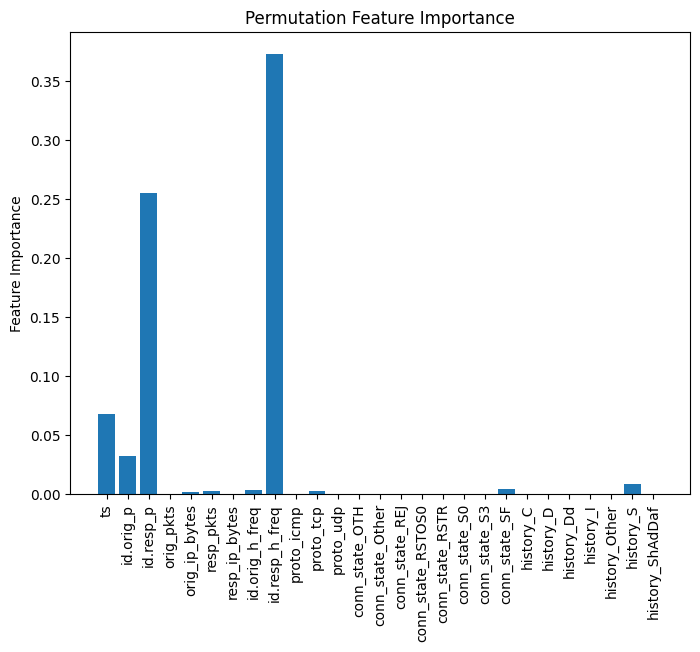

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(feature_importance.index, feature_importance.values)
ax.set_xticklabels(feature_importance.index, rotation=90)
ax.set_ylabel('Feature Importance')
ax.set_title('Permutation Feature Importance')
plt.show()

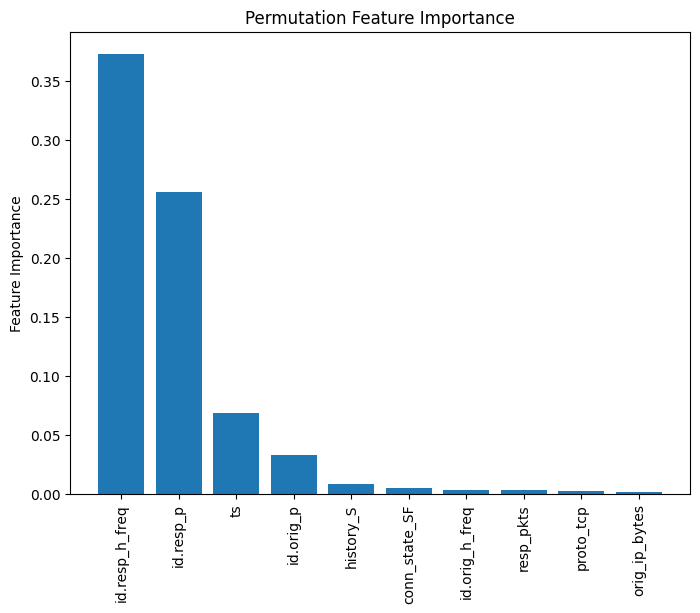

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(sorted_importance[:10].index, sorted_importance[:10].values)
ax.set_xticklabels(sorted_importance[:10].index, rotation=90)
ax.set_ylabel('Feature Importance')
ax.set_title('Permutation Feature Importance')
plt.show()

# نام گذاری مجدد

In [ ]:
X_train = X_train_engineered
X_test = X_test_engineered

# ذخیره‌ی مجموعه داده پیش پردازش و مهندسی شده

In [ ]:
# Save X_train and y_train into train.csv
train_df = pd.concat([X_train, y_train], axis=1)
train_df.to_csv('/content/drive/MyDrive/مواد پایان نامه/مجموعه داده‌های پیش پردازش و مهندسی شده/Train_Data.csv', index=False)

# Save X_test and y_test into test.csv
test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv('/content/drive/MyDrive/مواد پایان نامه/مجموعه داده‌های پیش پردازش و مهندسی شده/Test_Data.csv', index=False)

# فراخوانی داده

In [8]:
train_df = pd.read_csv("/content/drive/MyDrive/مواد پایان نامه/مجموعه داده‌های پیش پردازش و مهندسی شده/Train_Data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/مواد پایان نامه/مجموعه داده‌های پیش پردازش و مهندسی شده/Test_Data.csv")
X_train = train_df.drop("label", axis = 1)
y_train = train_df["label"]
X_test = test_df.drop("label", axis = 1)
y_test = test_df["label"]

In [ ]:
X_train

,id.resp_h_freq,id.resp_p,ts,id.orig_p,history_S,conn_state_SF,id.orig_h_freq,resp_pkts,proto_tcp,orig_ip_bytes
0,0.118657,2.069945,-1.523067,1.199170,0.536512,-0.245063,-1.031453,-0.011562,0.339079,-0.002710
1,-0.445184,-0.694609,0.814605,0.402619,0.536512,-0.245063,-1.019061,-0.011562,0.339079,-0.002698
2,-0.445184,-0.694609,0.878210,1.413284,0.536512,-0.245063,1.498223,-0.011562,0.339079,-0.002706
3,-0.445184,-0.694609,0.879966,1.413284,0.536512,-0.245063,1.498223,-0.011562,0.339079,-0.002706
4,-0.445184,-0.694609,0.813101,-0.000051,0.536512,-0.245063,-1.019061,-0.011562,0.339079,-0.002648
...,...,...,...,...,...,...,...,...,...,...
395947,-0.441746,1.993947,0.247678,-0.185365,0.536512,-0.245063,0.726963,-0.011562,0.339079,-0.002689
395948,-0.443656,-0.694656,-1.520921,0.068865,-1.863891,4.080583,-1.031453,0.306281,0.339079,-0.002419
395949,-0.443893,-0.694656,-1.521519,-0.121540,-1.863891,4.080583,-1.031453,0.322371,0.339079,-0.002408
395950,-0.444541,-0.694656,-1.521560,0.556080,-1.863891,4.080583,-1.031453,0.240414,0.339079,-0.002457


In [ ]:
y_train

0         5
1         5
2         5
3         5
4         5
         ..
395947    4
395948    4
395949    4
395950    4
395951    4
Name: label, Length: 395952, dtype: int64

# مدل Decision Tree

In [13]:
model_dt = DecisionTreeClassifier( random_state= 2023, criterion= 'entropy', max_depth= None, min_samples_leaf= 1, min_samples_split= 5 )
model_dt.fit(X_train, y_train)

y_pred_test_dt = model_dt.predict(X_test)
y_pred_train_dt = model_dt.predict(X_train)
y_pred_proba_dt = model_dt.predict_proba(X_test)
# Calculate test accuracy
test_accuracy = np.sum(y_pred_test_dt == y_test) / len(y_test)
train_accuracy = np.sum(y_pred_train_dt == y_train) / len(y_train)
print("Test accuracy:", test_accuracy)
print("Train accuracy:" , train_accuracy)


Test accuracy: 0.9998267047916125
Train accuracy: 0.9999949488826928


# مدل XG boost

In [9]:
# Train XGBoost model
model_xgb = XGBClassifier(random_state = 2023, max_depth = 3, learning_rate = 0.1, objective = "multi:softmax", num_class = len(np.unique(y_train)), eval_metric = 'merror')
model_xgb.fit(X_train, y_train)
# Make predictions on test set
y_pred_test_xgb = model_xgb.predict(X_test)
y_pred_train_xgb = model_xgb.predict(X_train)
y_pred_proba_xgb = model_xgb.predict_proba(X_test)
# Calculate test accuracy
test_accuracy = np.sum(y_pred_test_xgb == y_test) / len(y_test)
train_accuracy = np.sum(y_pred_train_xgb == y_train) / len(y_train)
print("Test accuracy:", test_accuracy)
print("Train accuracy:" , train_accuracy)



Test accuracy: 0.9976027496173064
Train accuracy: 0.9979568230492585


# مدل random forest

In [10]:
# Define the model with sample hyperparameters
model_RF = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', random_state=42)

# Train the model
model_RF.fit(X_train, y_train)

# Make predictions on train and test data
y_pred_train_RF = model_RF.predict(X_train)
y_pred_test_RF = model_RF.predict(X_test)
y_pred_proba_RF = model_RF.predict_proba(X_test)
# Calculate the accuracy of the model on train and test data
train_accuracy = accuracy_score(y_train, y_pred_train_RF)
test_accuracy = accuracy_score(y_test, y_pred_test_RF)

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)


Train accuracy: 0.9984088980482483
Test accuracy: 0.9981515177772001


# مدل extra tree

In [11]:
# Train the model on the training set
model_ETC = ExtraTreesClassifier(n_estimators = 70, random_state = 2023)
model_ETC.fit(X_train, y_train)

# Predict the target variable for train and test set
y_pred_train_ETC = model_ETC.predict(X_train)
y_pred_test_ETC = model_ETC.predict(X_test)
y_pred_proba_ETC = model_ETC.predict_proba(X_test)
# Evaluate the model on train and test set
train_accuracy = accuracy_score(y_train, y_pred_train_ETC)
test_accuracy = accuracy_score(y_test, y_pred_test_ETC)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 1.0
Test Accuracy: 0.9997111746526876


# مدل logistic


In [14]:
# Assuming y_pred_train_xgb, y_pred_train_RF, y_pred_train_lgb, y_pred_train_ETC are 1D arrays
meta_features = np.vstack((y_pred_train_xgb, y_pred_train_RF, y_pred_train_dt, y_pred_train_ETC)).T


In [ ]:
meta_features

array([5, 5, 5, ..., 4, 4, 4])

In [15]:
# standardize meta-features
scaler_meta = StandardScaler()
meta_features = scaler_meta.fit_transform(meta_features)

In [16]:
from sklearn.linear_model import LogisticRegression
# fit meta-learner
lr = LogisticRegression()
lr.fit(meta_features, y_train)


LogisticRegression()

In [17]:
meta_features_test = np.vstack((y_pred_test_xgb, y_pred_test_RF, y_pred_test_dt, y_pred_test_ETC)).T


In [18]:
meta_features_test = scaler_meta.transform(meta_features_test)

In [19]:
# predict using meta-learner
meta_predictions_test = lr.predict(meta_features_test)
meta_predictions_train = lr.predict(meta_features)
y_pred_proba_meta = lr.predict_proba(meta_features_test)

# evaluate model accuracy
accuracy_test = accuracy_score(y_test, meta_predictions_test)
accuracy_train = accuracy_score(y_train, meta_predictions_train)

print("Accuracy_test:", accuracy_test)
print("Accuracy_train:", accuracy_train)

Accuracy_test: 0.9996245270484938
Accuracy_train: 0.9999974744413465


# ۱۰ درصد داده برای hyperparameter tuning

In [26]:
import pandas as pd
from sklearn.utils import shuffle

# Calculate the number of samples to select from each class
num_samples_per_class = int(0.1 * train_df.shape[0] / len(train_df['label'].unique()))

# Create an empty DataFrame to store the sampled data
df_sampled = pd.DataFrame()

# Iterate over unique classes
for class_label in train_df['label'].unique():
    # Get samples for the current class
    samples = train_df[train_df['label'] == class_label].sample(n=num_samples_per_class, random_state=42)
    # Append the samples to df_sampled
    df_sampled = pd.concat([df_sampled, samples])

# Shuffle the sampled data
df_sampled = shuffle(df_sampled, random_state=42)

# Separate the features and labels from df_sampled
X_sampled = df_sampled.drop('label', axis=1)
y_sampled = df_sampled['label']


In [ ]:
X_sampled

# hyper parameter tuning for decision tree

In [12]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import tree
import matplotlib.pyplot as plt

# Prepare X_sampled and y_sampled from the sampled data

# Define the parameter grid for grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a decision tree classifier
dt = DecisionTreeClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5)
grid_search.fit(X_sampled, y_sampled)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


# نمودار جعبه‌ای برای Extra Trees

>5 0.999 (0.000)
>20 0.999 (0.000)
>40 0.999 (0.000)
>70 1.000 (0.000)
>100 0.999 (0.000)


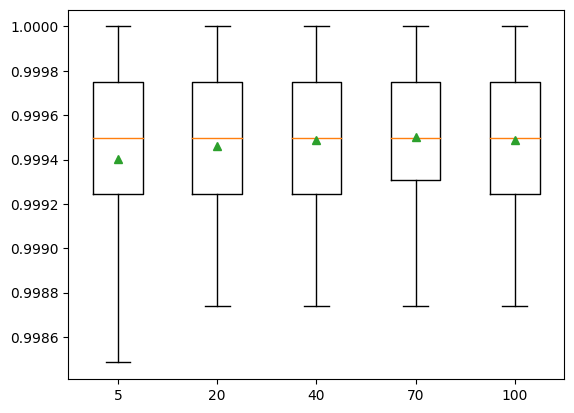

In [33]:
# explore extra trees number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from matplotlib import pyplot



# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [5, 20, 40, 70, 100]
	for n in n_trees:
		models[str(n)] = ExtraTreesClassifier(n_estimators=n, random_state=2023)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X, y = X_sampled, y_sampled
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# xgb رسم تابع زیان

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

eval_set = [(X_train, y_train), (X_test, y_test)]  # Evaluation dataset
model_xgb.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=True
)

# Extract the evaluation results
results = model_xgb.evals_result()

# Extract the training loss for each iteration
train_loss = results['validation_0']['merror']

# Plot the changing loss function
plt.figure(figsize=(10, 6))
plt.plot(train_loss)
plt.xlabel('Number of Trees')
plt.ylabel('Training Loss')
plt.title('Changing Training Loss')
plt.show()


# رسم درخت xgb

<Figure size 8000x4000 with 0 Axes>

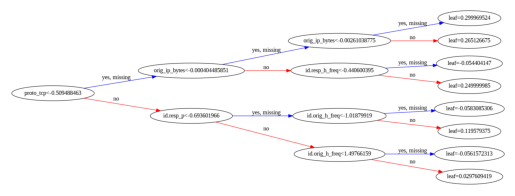

In [32]:
plt.figure(figsize=(20, 10), dpi=400)  # Increase DPI value for higher resolution
xgb.plot_tree(model_xgb, num_trees=0, rankdir='LR')
plt.savefig('xgboost_tree.png', dpi=400)  # Save the figure with higher resolution
plt.show()


# رسم درخت تصمیم

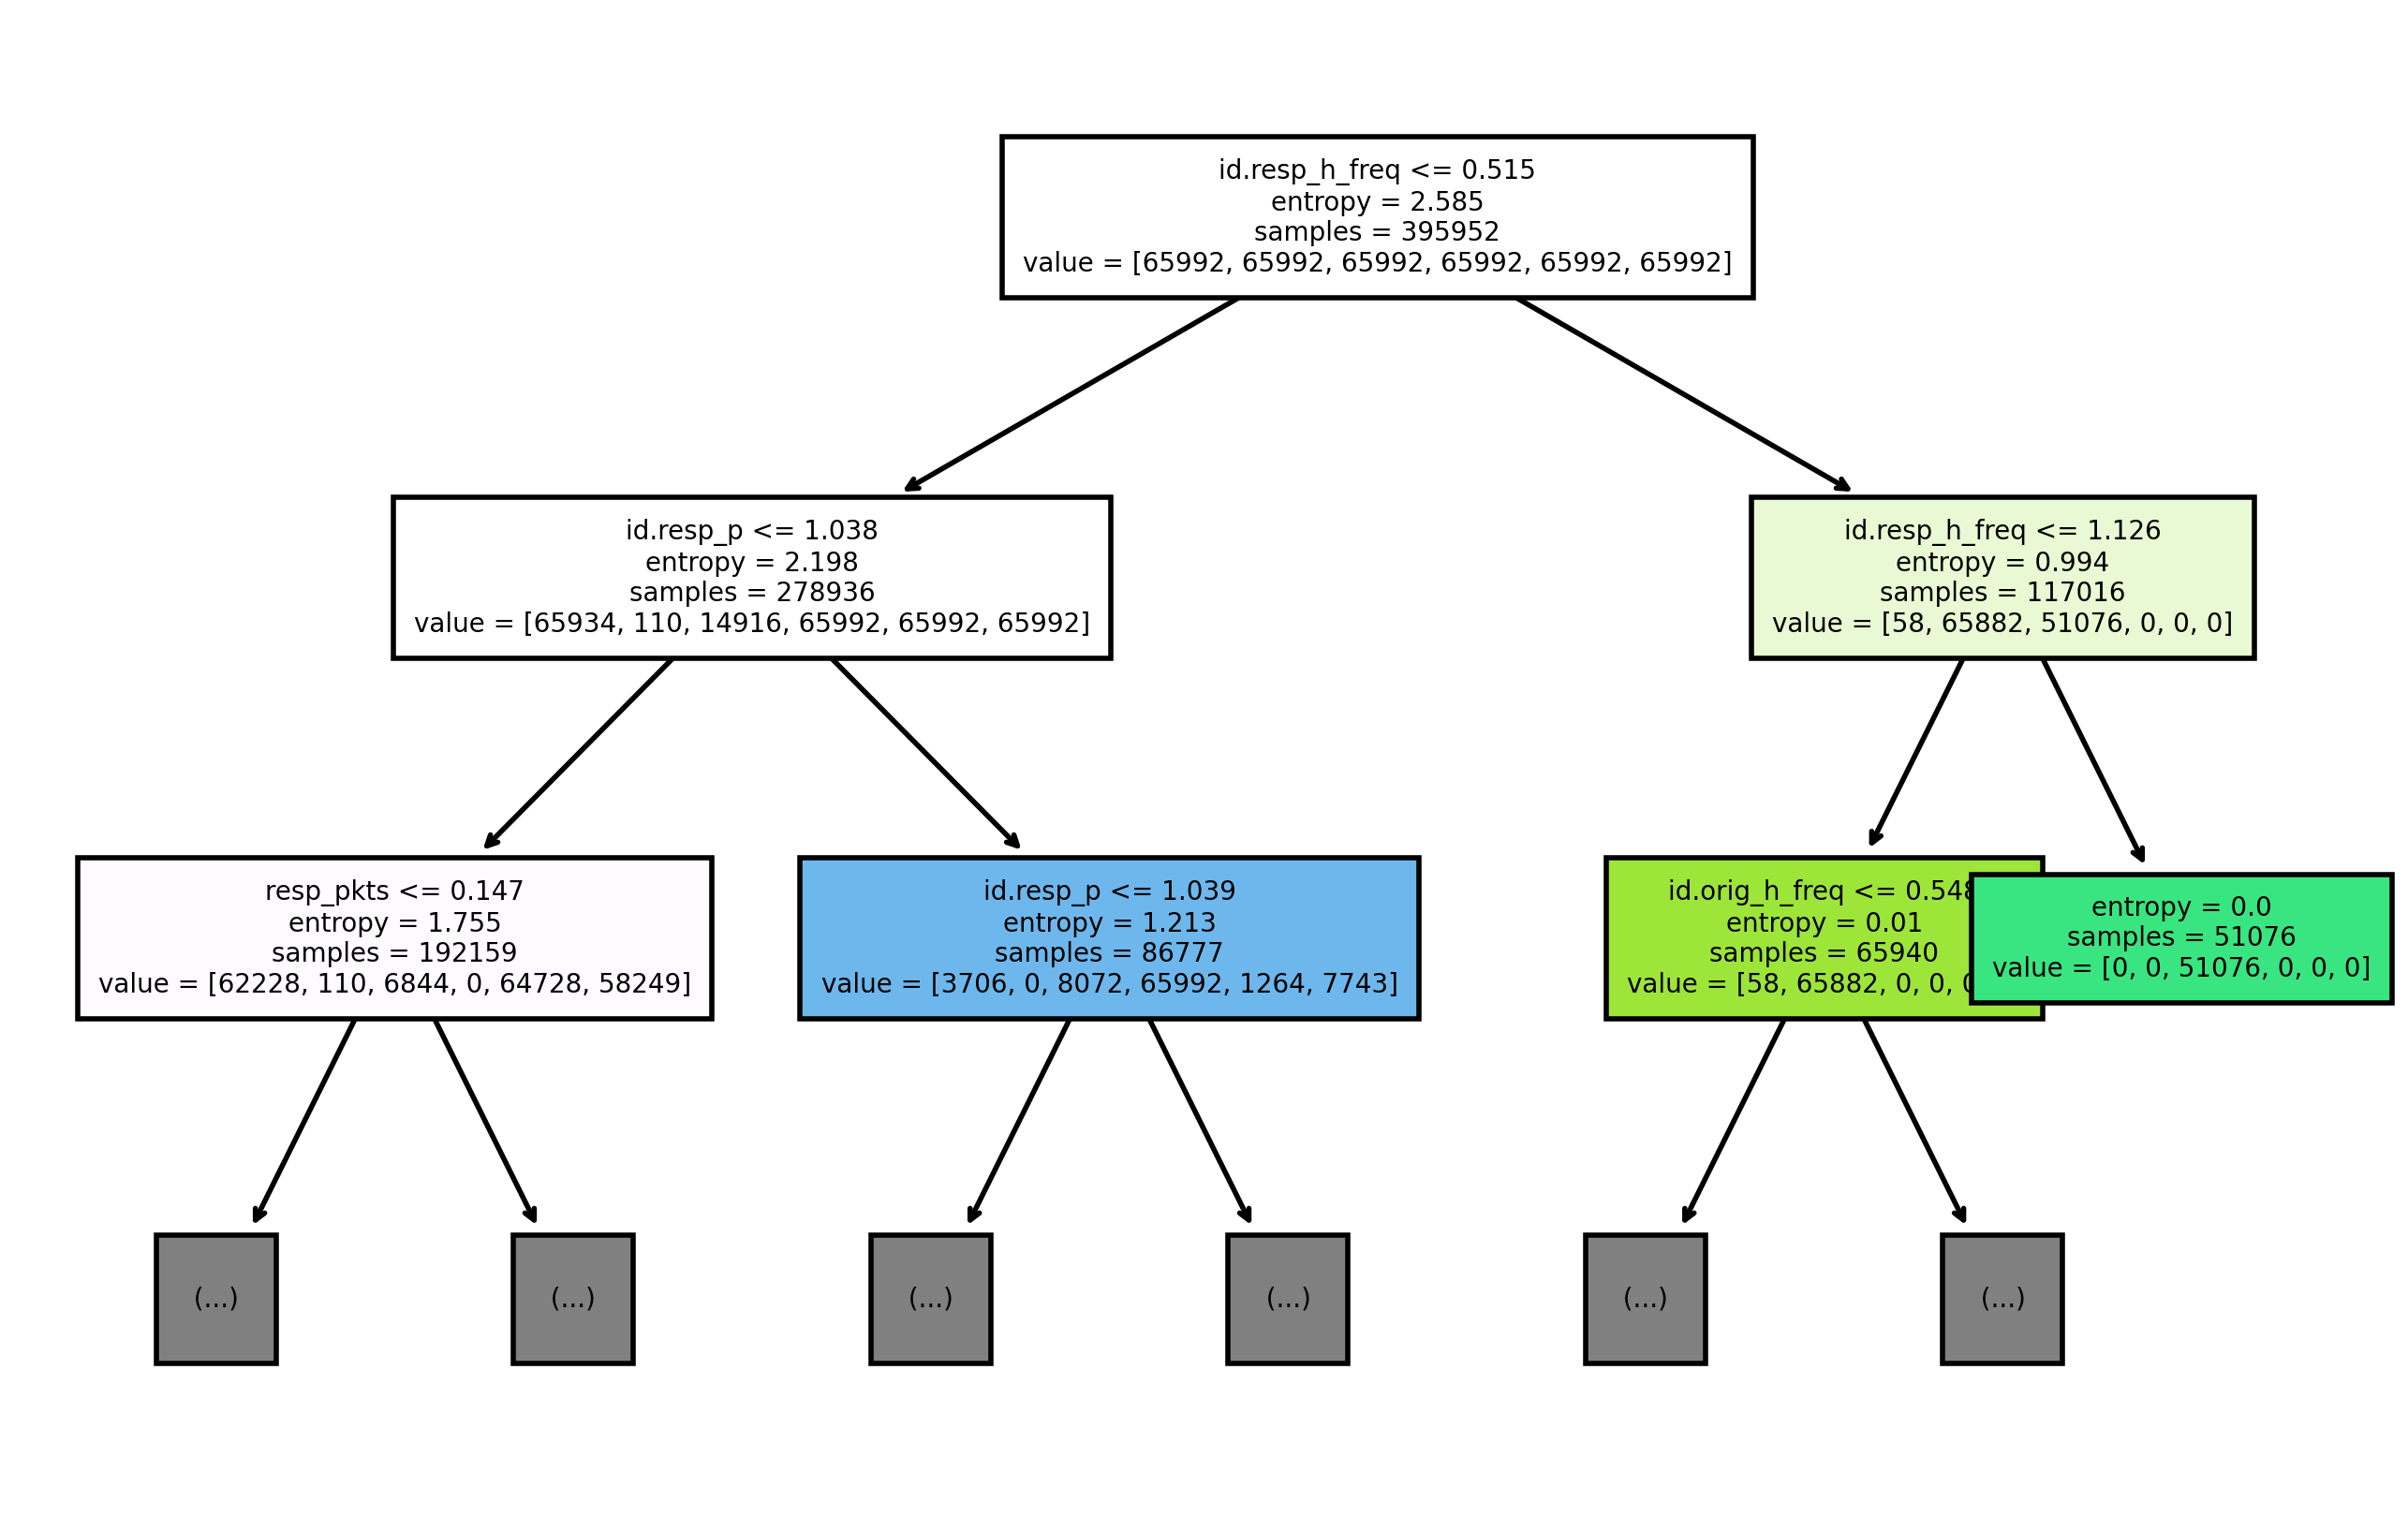

In [24]:
# Plot the decision tree with the best graphical view
from sklearn import tree
plt.figure(figsize=(8, 5), dpi = 400 )
tree.plot_tree(model_dt, feature_names=X_train.columns, filled=True, max_depth= 2, fontsize= 5)
plt.savefig('desicion_tree.png', dpi=400)
plt.show()

# رسم نمودار logistic regression

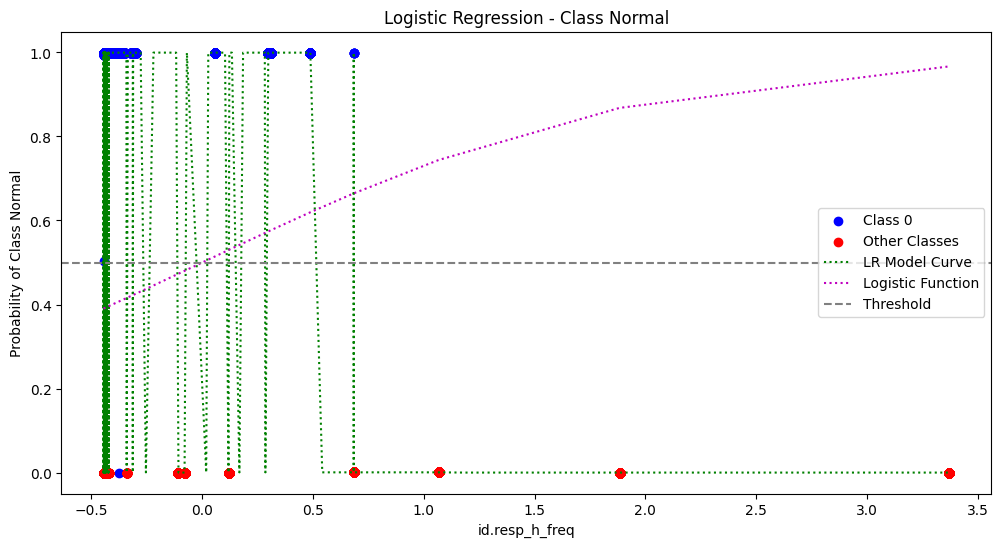

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Select the feature you want to plot
feature = 'id.resp_h_freq'

# Get the feature values and corresponding predicted probabilities for class 0
x_feature = X_train[feature]
x_feature_test = X_test[feature]
probs_class0 = lr.predict_proba(meta_features_test)[:, 0]
probs_class0_train = lr.predict_proba(meta_features)[:, 0]

# Create a mask to identify data points belonging to class 0
mask_class0 = y_train == 0
mask_class0_test = y_test == 0

# Sort the feature values in ascending order
sorted_idx = np.argsort(x_feature)
x_sorted = x_feature[sorted_idx]
probs_sorted = probs_class0_train[sorted_idx]

sorted_idx_test = np.argsort(x_feature_test)
x_sorted_test = x_feature_test[sorted_idx_test]

logistic = 1 / (1 + np.exp(-x_sorted_test))

plt.figure(figsize=(12, 6))

# Plot the data points for class 0 in blue
plt.scatter(x_feature_test[mask_class0_test], probs_class0[mask_class0_test], color='blue', label='Class 0')

# Plot the data points for other classes in red
plt.scatter(x_feature_test[~mask_class0_test], probs_class0[~mask_class0_test], color='red', label='Other Classes')

# Plot the LR model curve
plt.plot(x_sorted, probs_sorted, color='green', linestyle='dotted', label='LR Model Curve')


plt.plot(x_sorted_test, logistic, color='m', linestyle = ":", label='Logistic Function')

plt.axhline(y=0.5, color='gray', linestyle='--', label='Threshold')

# Set labels and title
plt.xlabel(feature)
plt.ylabel('Probability of Class Normal')
plt.title('Logistic Regression - Class Normal')

# Display legend
plt.legend()
plt.savefig('Logistic Regression - Class Normal.png', dpi=300)  # Save the figure with higher resolution

# Show the plot
plt.show()


# ارزیابی جامع داده

In [20]:
import pandas as pd
from sklearn.metrics import  confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

# Create an empty DataFrame to store the evaluation results
results_df = pd.DataFrame(columns=['Model Name', 'Accuracy', 'Recall', 'Precision', 'Specificity', 'F1 Score', 'AUC Score'])

def evaluate_model(y_test, y_pred, y_pred_proba, model_name):
    global results_df
    # y_test was not type of array because we cut it from data frame, on the other hand, all predicted values
    # from sk learn are type of array, so we convert y_test to type of array
    y_test = np.array(y_test)


    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    specificity = calculate_specificity_macro(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(y_test, y_pred_proba, multi_class = "ovr")

    # Store the results in a new row of the DataFrame
    results_df = results_df.append({'Model Name': model_name,
                                    'Accuracy': accuracy,
                                    'Recall': recall,
                                    'Precision': precision,
                                    'Specificity': specificity,
                                    'F1 Score': f1,
                                    'AUC Score': auc},
                                   ignore_index=True)

    return results_df


def calculate_specificity_macro(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    num_classes = cm.shape[0]
    specificity = np.zeros(num_classes)

    for i in range(num_classes):
        true_negative = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        total_negative = np.sum(np.delete(cm, i, axis=1))
        specificity[i] = true_negative / total_negative

    macro_specificity = np.mean(specificity)
    return macro_specificity





In [21]:
evaluate_model(y_test, y_pred_test_xgb, y_pred_proba_xgb, "XG Boost")
evaluate_model(y_test, y_pred_test_RF, y_pred_proba_RF, "Random Forest")
evaluate_model(y_test, y_pred_test_dt, y_pred_proba_dt, "Desicion Tree")
evaluate_model(y_test, y_pred_test_ETC, y_pred_proba_ETC, "Extra Tree")
evaluate_model(y_test, meta_predictions_test, y_pred_proba_meta, "stacking(logistic Regression)")



,Model Name,Accuracy,Recall,Precision,Specificity,F1 Score,AUC Score
0,XG Boost,0.997603,0.997812,0.975906,0.999509,0.985974,0.999991
1,Random Forest,0.998152,0.998344,0.999356,0.999622,0.998845,0.999991
2,Desicion Tree,0.999827,0.997933,0.999873,0.999966,0.998897,0.998941
3,Extra Tree,0.999711,0.997829,0.999899,0.999942,0.998858,1.000000
4,stacking(logistic Regression),0.999625,0.999664,0.985616,0.999923,0.992324,0.999847
